In [1]:
import awkward as ak
import numpy as np
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents.methods import vector
from pfnanoschema import PFNanoSchema
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import particle
import json

In [2]:
with open("filepaths.json", "r") as f:
    filepaths = json.load(f)

In [140]:
mMed = 1500
mDark = 20
ctau = 2000
iFile = 0

filepath = list(filepaths[f"s-channel_mMed-{mMed}_mDark-{mDark}_ctau-{ctau}_unflavored-down"]["files"].keys())[iFile]

In [141]:
events = NanoEventsFactory.from_root(
    { filepath: "Events" },
    schemaclass=PFNanoSchema
).events()

In [142]:
pdgId_dict = {
    1: "d",
    2: "u",
    3: "s",
    4: "c",
    5: "b",
    6: "t",
    21: "g",
    22: r"$\gamma$",
    111: r"$\pi^0$",
    310: r"$K^0_S$",
    3122: r"$\Lambda$",
    4900023: r"$X_{dk}$",
    4900101: r"$q_{dk}$",
    4900102: r"$q_{dk}$",
    4900103: r"$q_{dk}$",
    4900111: r"$\pi_{dk}$",
    4900113: r"$\eta_{dk}$",
    4900211: r"$\pi_{dk}$",
    4900213: r"$\eta_{dk}$",
}

In [143]:
def delta_r(eta1, phi1, eta2, phi2):
    dphi = (phi1 - phi2 + np.pi) % (2*np.pi) - np.pi
    deta = eta1 - eta2
    return np.sqrt(deta*deta + dphi*dphi)

In [144]:
def assignGenJet(jet_coll, genjet_coll, dR_threshold=0.4):

    jet_eta  = jet_coll.eta
    jet_phi  = jet_coll.phi

    gen_eta  = genjet_coll.eta
    gen_phi  = genjet_coll.phi

    # Broadcast to shape: [event, nJet, nGenJet]
    dR = delta_r(
        jet_eta[:, :, None], 
        jet_phi[:, :, None],
        gen_eta[:, None, :], 
        gen_phi[:, None, :]
    )

    best_genjet_idx = ak.argmin(dR, axis=2)  # shape: [event, nJet]
    best_dR = ak.min(dR, axis=2)
    
    match_mask = best_dR < dR_threshold

    masked_dR = ak.mask(best_dR, match_mask)
    matched_genjets = genjet_coll[best_genjet_idx]
    matched_genjets = ak.mask(matched_genjets, match_mask)

    jet_coll = ak.with_field(jet_coll, matched_genjets, "matchedGenJet")
    jet_coll = ak.with_field(jet_coll, masked_dR, "matchedGenJet_dR")
    jet_coll = ak.with_field(jet_coll, match_mask, "isMatchedGenJet")

    return jet_coll

In [145]:
def assignGenPart(pfcand_coll, genpart_coll, dR_threshold=0.4):

    pfcand_eta  = pfcand_coll.eta
    pfcand_phi  = pfcand_coll.phi

    genpart_eta  = genpart_coll.eta
    genpart_phi  = genpart_coll.phi

    dR = delta_r(
        pfcand_eta[:, :, None], 
        pfcand_phi[:, :, None],
        genpart_eta[:, None, :], 
        genpart_phi[:, None, :]
    )

    best_genpart_idx = ak.argmin(dR, axis=2)
    best_dR = ak.min(dR, axis=2)
    
    match_mask = best_dR < dR_threshold

    masked_dR = ak.mask(best_dR, match_mask)

    matched_genparts = genpart_coll[best_genpart_idx]
    matched_genparts = ak.mask(matched_genparts, match_mask)

    pfcand_coll = ak.with_field(pfcand_coll, matched_genparts, "matchedGenPart")
    pfcand_coll = ak.with_field(pfcand_coll, masked_dR, "matchedGenPart_dR")
    pfcand_coll = ak.with_field(pfcand_coll, match_mask, "isMatchedGenPart")

    pfcand_coll["matchedGenPart"] = ak.without_parameters(
        pfcand_coll["matchedGenPart"]
    )  # remove any previous awkward parameters
    pfcand_coll["matchedGenPart"] = ak.Array(pfcand_coll["matchedGenPart"], 
                                             behavior=vector.behavior)

    

    return pfcand_coll

In [146]:
def assignPFCandToJet(jet_coll, jetpfcand_coll, pfcand_coll):

    matchedPFC = pfcand_coll[jetpfcand_coll.pFCandsIdx]
    jetpfcands_with_pfcands = ak.with_field(jetpfcand_coll, matchedPFC, "PFCands")

    jet_idx = ak.local_index(jet_coll, axis=1)
    mask = jetpfcands_with_pfcands["jetIdx"][:, None] == jet_idx[:, :, None]

    jetpfcands_per_jet = ak.Array([ pfc[mask[i, j]] for i, pfc in enumerate(jetpfcands_with_pfcands) for j in range(len(jet_idx[i])) ])
    jetpfcands_per_jet = ak.unflatten(jetpfcands_per_jet, ak.num(jet_idx))

    jets_with_pfcands = ak.with_field(jet_coll, jetpfcands_per_jet, "JetPFCands")
    
    return jets_with_pfcands

In [147]:
print("Loading collections...")
jetPuppi = events.Jet
jetCHS = events.JetCHS
pfCands = events.PFCands
jetPuppiPFCands = events.JetPFCands
jetCHSPFCands = events.JetCHSPFCands

genJet = events.GenJet
genPart = events.GenPart
genJetCands = events.GenJetCands

print("Delta-R matching GenJets to Jets")
jetPuppi = assignGenJet(jetPuppi, genJet)
jetCHS = assignGenJet(jetCHS, genJet)

print("Delta-R mathcing GenPart to PFCand")
pfCands = assignGenPart(pfCands, genPart)

print("Assigning PFCands to Jets")
jetPuppi = assignPFCandToJet(jetPuppi, jetPuppiPFCands, pfCands)
jetCHS = assignPFCandToJet(jetCHS, jetCHSPFCands, pfCands)

Loading collections...
Delta-R matching GenJets to Jets
Delta-R mathcing GenPart to PFCand
Assigning PFCands to Jets


In [148]:
def plot_gen_ancestry(ax_etaphi, ax_rz, genpart, genpart_collection, etamin, etamax, phimin, phimax, rmin, rmax, zmin, zmax, color='grey', alpha=0.6, ancestor=False):
    mother_idx = genpart.genPartIdxMother
    if mother_idx == -1 or mother_idx is None:  # end of chain
        return
    
    mother = genpart_collection[mother_idx]
    
    z_txt_offset = (zmax-zmin)/70
    phi_txt_offset = (phimax-phimin)/100
    r_txt_offset = (rmax-rmin)/30
    eta_txt_offset = (etamax-etamin)/50

    # plot marker if ancestor
    if ancestor:
        ax_etaphi.plot(genpart.eta, genpart.phi, color='purple', linestyle="", marker='*', markersize=10,markeredgecolor='none')
        ax_rz.plot(np.sqrt(genpart.eta**2+genpart.phi**2), genpart.vz, color='purple', linestyle="", marker='*', markersize=10,markeredgecolor='none')

    
    # plot line from particle to mother
    ax_etaphi.plot([genpart.eta, mother.eta], [genpart.phi, mother.phi],
            marker=None, linestyle='dashed', color=color, alpha=alpha)
    ax_rz.plot([np.sqrt(genpart.eta**2+genpart.phi**2), np.sqrt(mother.eta**2+mother.phi**2)], [genpart.vz, mother.vz],
            marker=None, linestyle='dashed', color=color, alpha=alpha)

    if abs(genpart.pdgId) in pdgId_dict:
        pdgIdStr = pdgId_dict[abs(genpart.pdgId)]
    else: 
        pdgIdStr = str(genpart.pdgId)
        
    if ((rmin < np.sqrt(genpart.eta**2+genpart.phi**2)) and (np.sqrt(genpart.eta**2+genpart.phi**2) < rmax)) and (((zmin < genpart.vz) and (genpart.vz  < zmax))):
            ax_rz.text(np.sqrt(genpart.eta**2+genpart.phi**2)+r_txt_offset,
                       genpart.vz+z_txt_offset,
                       pdgIdStr,
                       fontsize=10)
    if ((etamin < genpart.eta) and (genpart.eta < etamax)) and (((phimin < genpart.phi) and (genpart.phi  < phimax))):
            ax_etaphi.text(genpart.eta+eta_txt_offset,
                           genpart.phi+phi_txt_offset,
                           pdgIdStr,
                           fontsize=10)
        
    
    # handle phi wrapping for circular plot
    if abs(genpart.phi - mother.phi) > np.pi:
        if genpart.phi > mother.phi:
            ax_etaphi.plot([genpart.eta, mother.eta], [genpart.phi - 2*np.pi, mother.phi], 
                    marker=None, linestyle='dashed', color=color, alpha=alpha)
        else:
            ax_etaphi.plot([genpart.eta, mother.eta], [genpart.phi + 2*np.pi, mother.phi], 
                    marker=None, linestyle='dashed', color=color, alpha=alpha)
    
    # recurse
    plot_gen_ancestry(ax_etaphi, ax_rz, mother, genpart_collection, etamin, etamax, phimin, phimax, rmin, rmax, zmin, zmax, color=color, alpha=alpha, ancestor=True)

In [149]:
def plotEvent(iEvt, jetPuppi, jetCHS, genPart, etamin=None, etamax=None, phimin=None, phimax=None, zmin=None, zmax=None, rmin=None, rmax=None):
    fig,axs = plt.subplots(1,3,figsize=(20,12),gridspec_kw={'width_ratios': [2, 1.5, 1]})

    axs[0].set_xlabel(r"$\eta$")
    axs[0].set_ylabel(r"$\phi$")
    axs[1].set_xlabel(r"R [mm]")
    axs[1].set_ylabel(r"z [mm]")

    # plot genPart
    axs[0].plot(genPart[iEvt].eta, genPart[iEvt].phi, color='r', linestyle="", marker='o', markersize=3,markeredgecolor='none')
    axs[1].plot(np.sqrt(genPart[iEvt].eta**2+genPart[iEvt].phi**2), genPart[iEvt].vz, color='r', linestyle="", marker='o', markersize=3,markeredgecolor='none')

    avg_jet_eta = np.average(jetPuppi[iEvt].eta)

    # figure out axis limits
    if (etamin is None) or (etamax is None):
        etamin = avg_jet_eta-4
        etamax = avg_jet_eta+4
    if (phimin is None) or (phimax is None):
        phimin = -3.5
        phimax = 3.5
    if (zmin is None) or (zmax is None):
        zmin = 0
        zmax = max(genPart[iEvt].vz)
    if (rmin is None) or (rmax is None):
        rmin = -5
        rmax = 5

    z_txt_offset = (zmax-zmin)/70
    phi_txt_offset = (phimax-phimin)/100
    r_txt_offset = (rmax-rmin)/30
    eta_txt_offset = (etamax-etamin)/50
            
    # plot CHS jets
    for i, jet in enumerate(jetCHS[iEvt]):
        circle = plt.Circle((jet.eta, jet.phi), 0.4, facecolor='orange', edgecolor = 'orange', alpha=0.2)
        axs[0].add_patch(circle)
        if jet.phi>np.pi-0.4:
            circle2 = plt.Circle((jet.eta, jet.phi-2*np.pi), 0.4, facecolor='orange', edgecolor = 'orange', alpha=0.2)
            axs[0].add_patch(circle2)
        elif jet.phi<-np.pi+0.4:
            circle2 = plt.Circle((jet.eta, jet.phi+2*np.pi), 0.4, facecolor='orange', edgecolor = 'orange', alpha=0.2)
            axs[0].add_patch(circle2)
            
        axs[0].plot(jet.JetPFCands.PFCands.eta, jet.JetPFCands.PFCands.phi, color='orange', linestyle="", marker='o', markersize=10,markeredgecolor='none')
        axs[0].plot(jet.JetPFCands.PFCands.matchedGenPart.eta, jet.JetPFCands.PFCands.matchedGenPart.phi, color='k', linestyle="", marker='o', markersize=3,markeredgecolor='none')

        # axs[1].plot(np.sqrt(jet.JetPFCands.PFCands.eta**2+jet.JetPFCands.PFCands.phi**2), jet.JetPFCands.PFCands.vz, color='orange', linestyle="", marker='o', markersize=10,markeredgecolor='none')
        axs[1].plot(np.sqrt(jet.JetPFCands.PFCands.matchedGenPart.eta**2+jet.JetPFCands.PFCands.matchedGenPart.phi**2), jet.JetPFCands.PFCands.matchedGenPart.vz, color='k', linestyle="", marker='o', markersize=5,markeredgecolor='none')


    # plot Puppi jets
    for i, jet in enumerate(jetPuppi[iEvt]):
        circle = plt.Circle((jet.eta, jet.phi), 0.4, facecolor='teal', edgecolor = 'teal', alpha=0.2)
        axs[0].add_patch(circle)
        if jet.phi>np.pi-0.4:
            circle2 = plt.Circle((jet.eta, jet.phi-2*np.pi), 0.4, facecolor='teal', edgecolor = 'teal', alpha=0.2)
            axs[0].add_patch(circle2)
        elif jet.phi<-np.pi+0.4:
            circle2 = plt.Circle((jet.eta, jet.phi+2*np.pi), 0.4, facecolor='teal', edgecolor = 'teal', alpha=0.2)
            axs[0].add_patch(circle2)


        for j, pfcand in enumerate(jet.JetPFCands.PFCands):
            if pfcand.matchedGenPart is not None:
                if abs(pfcand.matchedGenPart.pdgId) in pdgId_dict:
                    pdgIdStr = pdgId_dict[abs(pfcand.matchedGenPart.pdgId)]
                else: 
                    pdgIdStr = str(pfcand.matchedGenPart.pdgId)
                if ((etamin < pfcand.matchedGenPart.eta) and (pfcand.matchedGenPart.eta < etamax)) and (((phimin < pfcand.matchedGenPart.phi) and (pfcand.matchedGenPart.phi < phimax))):
                    axs[0].text(pfcand.matchedGenPart.eta+eta_txt_offset,
                                pfcand.matchedGenPart.phi+phi_txt_offset,
                                pdgIdStr,
                                fontsize=10)
                if (((rmin < np.sqrt(pfcand.matchedGenPart.eta**2+pfcand.matchedGenPart.phi**2)) and (np.sqrt(pfcand.matchedGenPart.eta**2+pfcand.matchedGenPart.phi**2) < rmax)) 
                    and (((zmin < pfcand.matchedGenPart.vz) and (pfcand.matchedGenPart.vz < zmax)))):
                    axs[1].text(np.sqrt(pfcand.matchedGenPart.eta**2+pfcand.matchedGenPart.phi**2)+r_txt_offset,
                                pfcand.matchedGenPart.vz+z_txt_offset,
                                pdgIdStr,
                                fontsize=10)
                plot_gen_ancestry(axs[0], axs[1], pfcand.matchedGenPart, genPart[iEvt], etamin, etamax, phimin, phimax, rmin, rmax, zmin, zmax, color='grey', alpha=0.6)
        axs[0].plot(jet.JetPFCands.PFCands.eta, jet.JetPFCands.PFCands.phi, color='teal', linestyle="", marker='o', markersize=7,markeredgecolor='none')
        axs[0].plot(jet.JetPFCands.PFCands.matchedGenPart.eta, jet.JetPFCands.PFCands.matchedGenPart.phi, color='k', linestyle="", marker='o', markersize=3,markeredgecolor='none')
                

    legend_elements = [
        Patch(facecolor='teal', edgecolor='teal', alpha=0.2, label='Puppi Jets'), 
        Patch(facecolor='orange', edgecolor='orange', alpha=0.2, label='CHS Jets'),
        Line2D([0], [0], marker='.', color='teal', label='Puppi PFCand', markersize=7, linestyle='None'),
        Line2D([0], [0], marker='.', color='orange', label='CHS PFCand', markersize=10, linestyle='None'),
        Line2D([0], [0], marker='.', color='k', label='matched GenPart', markersize=5, linestyle='None'),
        Line2D([0], [0], marker='.', color='r', label='genPart', markersize=5, linestyle='None'),
        Line2D([0], [0], marker='*', color='purple', label='genPart ancestor', markersize=10, linestyle='None'),
    ]

    legend1 = plt.legend(handles=legend_elements,
                         loc='upper left')
    
    axs[2].add_artist(legend1)

    axs[0].fill_between([-10,10],np.pi,np.pi+1,color='lightgray',alpha=0.85)
    axs[0].fill_between([-10,10],-1-np.pi,-np.pi,color='lightgray',alpha=0.85)
    axs[0].set_xlim([float(etamin), float(etamax)])
    axs[0].set_ylim([float(phimin), float(phimax)])

    axs[1].set_xlim([float(rmin), float(rmax)])
    axs[1].set_ylim([float(zmin), float(zmax)])

    # make second subplot invisible (just used to get legends to show up nicely)
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['bottom'].set_visible(False)
    axs[2].spines['left'].set_visible(False)
    axs[2].get_xaxis().set_ticks([])
    axs[2].get_yaxis().set_ticks([])
    
    fig.tight_layout()

    fig.show()

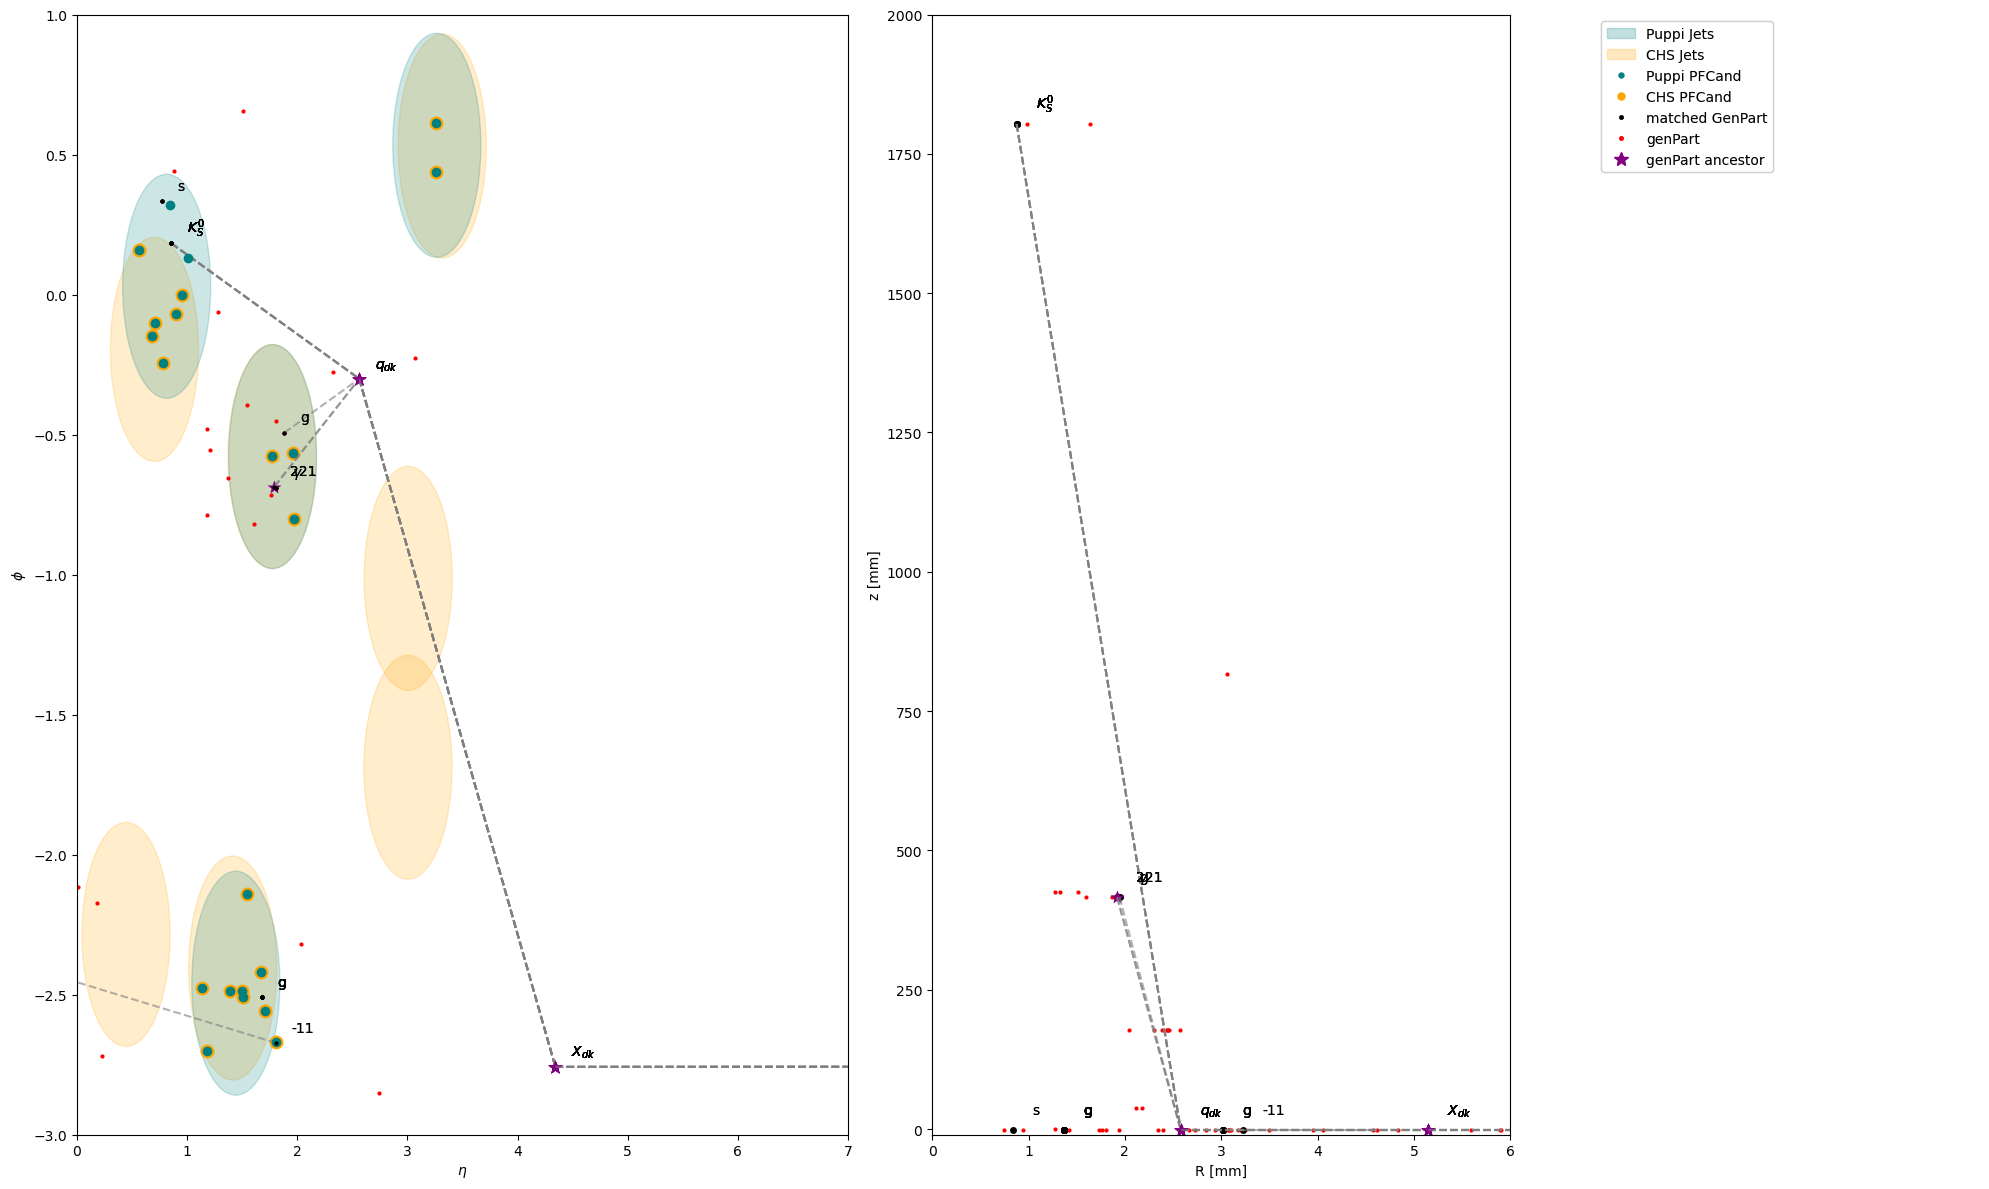

In [169]:
plotEvent(66, jetPuppi, jetCHS, genPart, etamin=0, etamax=7, phimin=-3, phimax=1, rmin=0, rmax=6, zmin=-10, zmax=2000)